# Analysis-Multimodal detection with KDE

Desarrollar y probar herramientas para la deteccion de distribuciones embebidas dentro de una variable (1D). Si es posible, se apliara el analisis a 2D. Para ello sera usado un KDE optimizado y el DIP test que evalua si una variable es unimodal o no.


### References

- [Modality tests and kernel density estimations (toward data science)](https://towardsdatascience.com/modality-tests-and-kernel-density-estimations-3f349bb9e595) --> [notebook](https://github.com/ciortanmadalina/modality_tests/blob/master/kernel_density.ipynb)


In [1]:
!pip install unidip
!pip install simdkalman

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import simdkalman

## function

In [3]:
def test_ks2(data1, data2):
    from scipy.stats import ks_2samp
    stat, p = ks_2samp(data1, data2)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')
        
def test_uniform_num(data):
    from scipy.stats import uniform, ks_2samp
    dismin=np.amin(data)
    dismax=np.amax(data)
    T=uniform(dismin,dismax-dismin).rvs(data.shape[0])
    stat, p = ks_2samp(data, T)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably is Uniform')
    else:
        print('Probably is not Uniform') 

## Iris dataset

<AxesSubplot:ylabel='Density'>

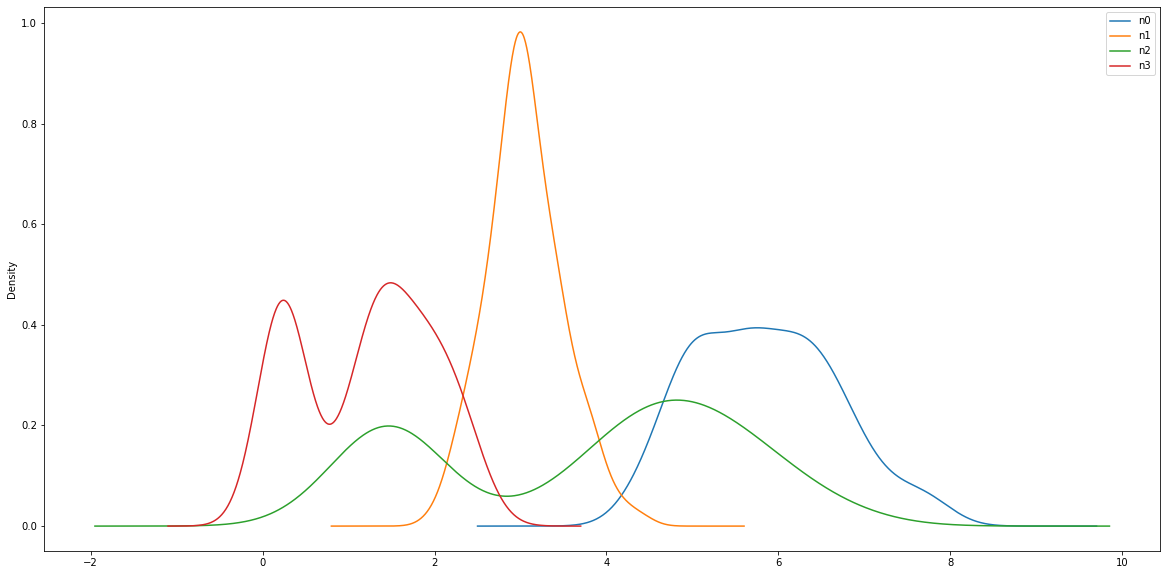

In [4]:
## DATASET

# load dataset
dataset = load_iris()
dataset.keys()
# dataset to df
data = pd.DataFrame(dataset.data, columns = dataset.feature_names)
"""
data['class'] = dataset.target
dclass = dict()
for i, ic in enumerate(dataset.target_names):
    dclass[i] = ic
"""

## FORMAT 

# check what columns are NUMERICAL or CATEGORICAL
cols_num = data.select_dtypes(include=['float64', 'int64']).columns.values  # numerical columns
cols_cat = data.select_dtypes(include=['object']).columns.values            # categorical columns
# columns name converters: numerical
dcols_num_name_to_alias = dict()
dcols_num_alias_to_name = dict()
for i, ic in enumerate(cols_num):
    dcols_num_name_to_alias[ic] = 'n{}'.format(i)
    dcols_num_alias_to_name['n{}'.format(i)] = ic
# columns name converters: categorical
dcols_cat_name_to_alias = dict()
dcols_cat_alias_to_name = dict()
for i, ic in enumerate(cols_cat):
    dcols_cat_name_to_alias[ic] = 'c{}'.format(i)
    dcols_cat_alias_to_name['c{}'.format(i)] = ic
# rename columns
data.rename(columns = dcols_num_name_to_alias, inplace = True)
data.rename(columns = dcols_cat_name_to_alias, inplace = True)
# list of alias
cols_num_alias = list(dcols_num_name_to_alias.values())
cols_cat_alias = list(dcols_cat_name_to_alias.values())

## PLOT

data.plot.kde(figsize = (20,10))

# Uniform distribution data

<AxesSubplot:ylabel='Frequency'>

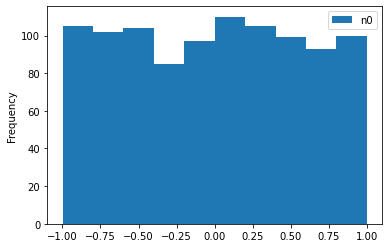

In [5]:
# random data
s = np.random.uniform(-1,1,1000)
# to df
datarandom = pd.DataFrame({'n0':s})
# plot
datarandom.plot(kind = 'hist', bins = 10)

# Gaussian distribution data (Unimodal, Multimodal)

<AxesSubplot:ylabel='Frequency'>

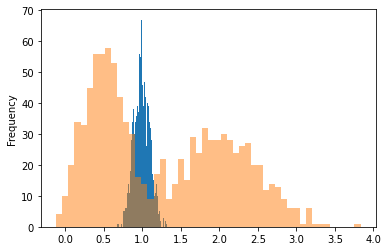

In [6]:
## Unimodal
mu, sigma = 1, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
datagauss = pd.DataFrame({'uni': s})
## Multimodal
mu1, sigma1 = 2, 0.5 # mean and standard deviation
s1 = np.random.normal(mu1, sigma1, 500)
s = np.concatenate((s1, 0.5*s1 - .5))
datagauss['multi'] = s
## plot
datagauss.uni.plot(kind = 'hist', bins = 50)
datagauss.multi.plot(kind = 'hist', bins = 50, alpha = .5)

# ANALYSIS 1D

## KDE

In [7]:
def getExtremePoints(data, typeOfInflexion = None, maxPoints = None):
    """
    This method returns the indeces where there is a change in the trend of the input series.
    typeOfInflexion = None returns all inflexion points, max only maximum values and min
    only min,
    """
    a = np.diff(data)
    asign = np.sign(a)
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    idx = np.where(signchange ==1)[0]

    if typeOfInflexion == 'max' and data[idx[0]] < data[idx[1]]:
        idx = idx[1:][::2]
        
    elif typeOfInflexion == 'min' and data[idx[0]] > data[idx[1]]:
        idx = idx[1:][::2]
    elif typeOfInflexion is not None:
        idx = idx[::2]
    
    # sort ids by min value
    if 0 in idx:
        idx = np.delete(idx, 0)
    if (len(data)-1) in idx:
        idx = np.delete(idx, len(data)-1)
    idx = idx[np.argsort(data[idx])]
    # If we have maxpoints we want to make sure the timeseries has a cutpoint
    # in each segment, not all on a small interval
    if maxPoints is not None:
        idx= idx[:maxPoints]
        if len(idx) < maxPoints:
            return (np.arange(maxPoints) + 1) * (len(data)//(maxPoints + 1))
    
    return idx

In [8]:
## Get pdf estimated with KDE for 1D data
def get_pdf_1d(v:np.array)->(np.array, np.array, np.array):
    """
    Get pdf estimated with KDE for 1D data.
    v - 1D data array.
    return - (x, pdf, local maximum)
    """
    # get x values
    x = np.linspace(v.min(),v.max(), v.shape[0])
    # get kde kernel
    from scipy import stats
    kernel = stats.gaussian_kde(v)    
    # get local maximum
    idx = getExtremePoints(kernel(x), typeOfInflexion='max')
    # return
    return x, kernel(x), idx
    
## Plot pdf estimated with KDE for 1D data
def plot_pdf_1d(v:np.array):
    # get pdf
    x, pdf_kde, local_max = get_pdf_1d(v)
    # plot
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize= (14, 6))
    ax.plot(x, pdf_kde, alpha = 0.8, label = f'Statsmodels CV maximum likelihood')
    for i in local_max:
        ax.scatter(x[i], pdf_kde[i], s= 40, c = 'red')
    for i in local_max:
        ax.annotate(f' Max = {round(x[i], 2)}', (x[i], pdf_kde[i]))
    plt.show()

## DIP test

In [9]:
def test_dip(data, alpha = 0.05, verbose = True)->bool:
    import unidip.dip as dip
    # sort data
    data = np.msort(data)
    # test
    stat, p, _ = dip.diptst(data)
    # display
    if verbose:
        print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably unimodal')
    else:
        print('Probably not unimodal.')

## Iris dataset

VARIABLE "n0"
stat=0.153, p=0.053
Probably is Uniform
stat=0.040, p=0.965
Probably unimodal
Number of modals = 1


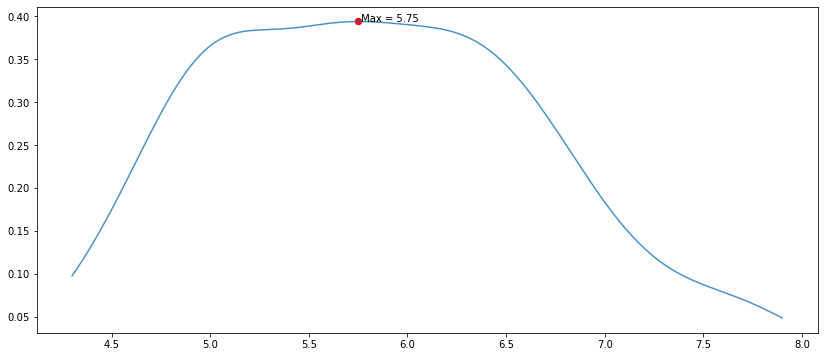

VARIABLE "n1"
stat=0.180, p=0.013
Probably is not Uniform
stat=0.087, p=0.160
Probably unimodal
Number of modals = 1


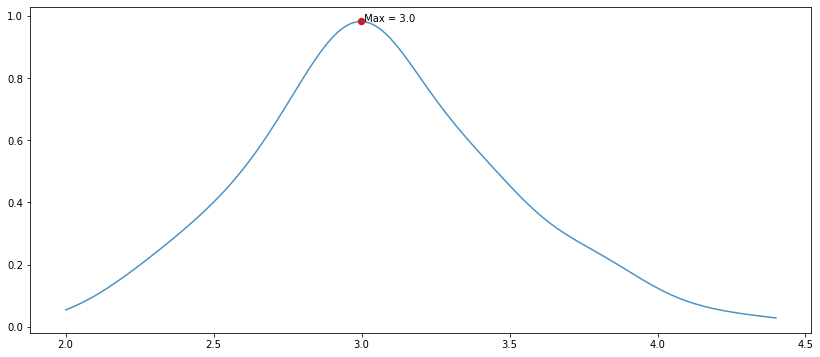

VARIABLE "n2"
stat=0.193, p=0.006
Probably is not Uniform
stat=0.119, p=0.001
Probably not unimodal.
Number of modals = 2


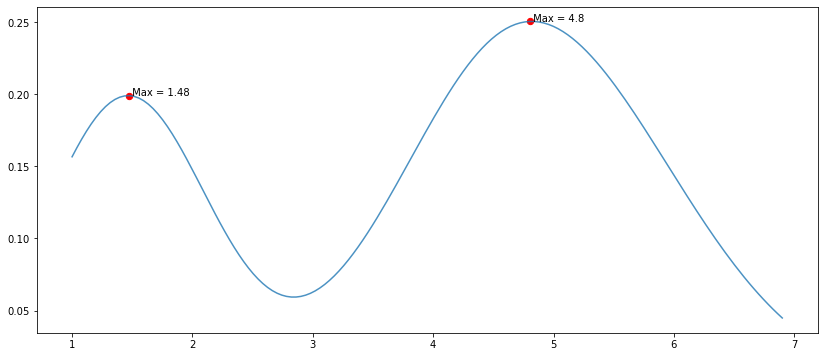

VARIABLE "n3"
stat=0.187, p=0.009
Probably is not Uniform
stat=0.097, p=0.071
Probably unimodal
Number of modals = 2


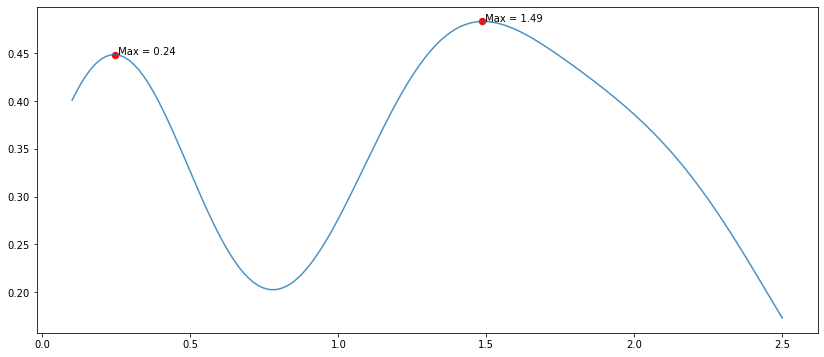

In [10]:
for col in data.columns.tolist():
    # display
    print(f'VARIABLE "{col}"')
    # collect data
    v = data[col].values
    # test uniform
    test_uniform_num(v)
    # dip test
    test_dip(v, alpha = .05)
    # get pdf and local maximuns
    pdf_kde, x, local_max = get_pdf_1d(v)
    # display results
    print(f'Number of modals = {len(local_max)}')
    # plot
    plot_pdf_1d(v)

### Uniform dist data

stat=0.029, p=0.789
Probably is Uniform
stat=0.011, p=0.593
Probably unimodal
Number of modals = 2


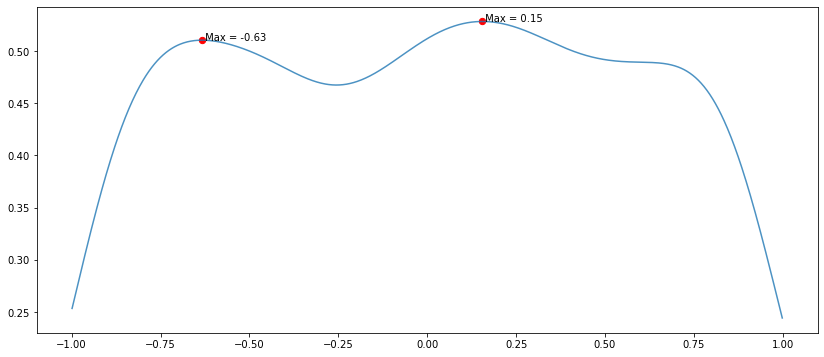

In [11]:
# collect data
v = datarandom['n0'].values
# test uniform
test_uniform_num(v)
# dip test
test_dip(v, alpha = .05)
# get pdf and local maximuns
pdf_kde, x, local_max = get_pdf_1d(v)
# display results
print(f'Number of modals = {len(local_max)}')
# plot
plot_pdf_1d(v)

#### Conclusiones

- Cuando se detecte que la distribucion de la data es uniforme (random), mejor no aplicar el analisis unimodal pues se va a equivocar.

### data gauss unimodal

stat=0.209, p=0.000
Probably is not Uniform
stat=0.007, p=0.994
Probably unimodal
Number of modals = 1


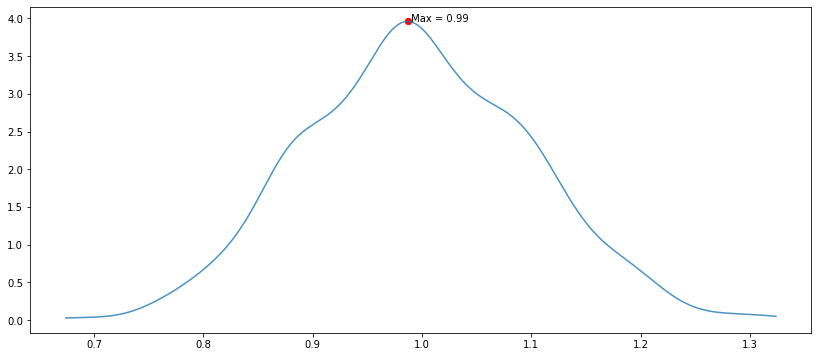

In [12]:
# collect data
v = datagauss['uni'].values
# test uniform
test_uniform_num(v)
# dip test
test_dip(v, alpha = .05)
# get pdf and local maximuns
pdf_kde, x, local_max = get_pdf_1d(v)
# display results
print(f'Number of modals = {len(local_max)}')
# plot
plot_pdf_1d(v)

### data gauss multimodal

stat=0.218, p=0.000
Probably is not Uniform
stat=0.030, p=0.001
Probably not unimodal.
Number of modals = 2


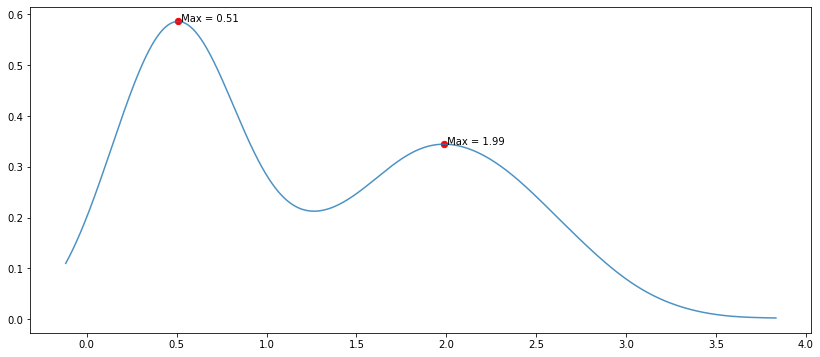

In [13]:
# collect data
v = datagauss['multi'].values
# test uniform
test_uniform_num(v)
# dip test
test_dip(v, alpha = .05)
# get pdf and local maximuns
pdf_kde, x, local_max = get_pdf_1d(v)
# display results
print(f'Number of modals = {len(local_max)}')
# plot
plot_pdf_1d(v)

## MODALS CLUSTERIZATION

- https://cmdlinetips.com/2021/03/gaussian-mixture-models-with-scikit-learn-in-python/amp/
- https://pypi.org/project/unidip/

In [14]:
## Estimate 1d clusters with KDE
def get_1d_clusters_kde(v:np.array, verbose = True)->np.array:
    """
    Estimate 1d clusters with KDE.
    v -- data array to be used.
    verbose -- display extra information (default, True)
    result -- array of estimated labels.
    """
    
    # get pdf and local maximuns
    pdf_kde, x, local_max = get_pdf_1d(v)
    # display results
    num_modals = len(local_max)
    # display
    if verbose:
        print(f'number of modals = {num_modals}')
    # reshape data
    v = v.reshape(-1, 1)
    # KDE algorithm
    from sklearn.mixture import GaussianMixture
    gmm = GaussianMixture(num_modals, covariance_type='full', random_state=0).fit(v)
    # get cluster means
    cluster_means = [cm for cm in gmm.means_]
    # display
    if verbose:
        print(f'cluster means: {cluster_means}')
    # get labels
    labels = gmm.predict(v)
    # return
    return labels

## Plot 1d clusters
def plot_1d_clusters_kde(v, labels):
    """
    Plot 1d clusters.
    v -- original data.
    labels -- its respective clusters.
    """
    # data and labels to df
    result = pd.DataFrame({'data':v.ravel(), 'cluster': labels})
    # get unique values of clusters
    clusters = sorted(list(result.cluster.unique()))
    # plot
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    colors = ['green', 'blue', 'red', 'yellow', 'orange', 'grey']
    for cluster, color in zip(clusters, colors[:len(clusters)]):
        temp = result[result.cluster == cluster]
        iv = temp.data.values
        ax.hist(iv, color = color, alpha = 0.5)
        del iv
    ax.set_title(f'number of clusters = {len(clusters)}')
    plt.show()

### Iris dataset

VARIABLE "n0"
stat=0.140, p=0.097
Probably is Uniform
stat=0.040, p=0.962
Probably unimodal
number of modals = 1
cluster means: [array([5.84333333])]


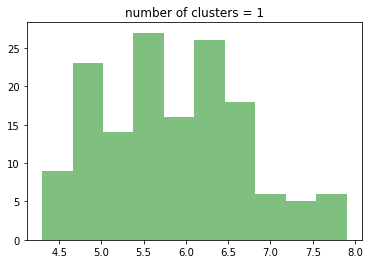

VARIABLE "n1"
stat=0.253, p=0.000
Probably is not Uniform
stat=0.087, p=0.130
Probably unimodal
number of modals = 1
cluster means: [array([3.05733333])]


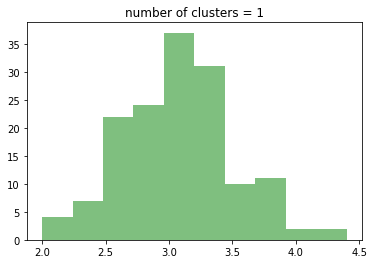

VARIABLE "n2"
stat=0.180, p=0.013
Probably is not Uniform
stat=0.119, p=0.001
Probably not unimodal.
number of modals = 2
cluster means: [array([1.46175017]), array([4.90497803])]


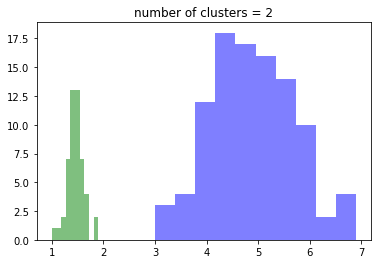

VARIABLE "n3"
stat=0.187, p=0.009
Probably is not Uniform
stat=0.097, p=0.077
Probably unimodal
number of modals = 2
cluster means: [array([0.23500397]), array([1.65412289])]


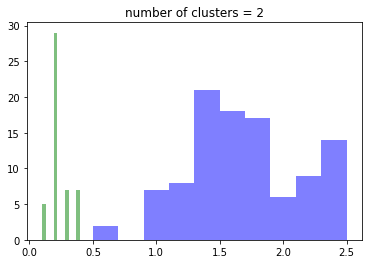

In [15]:
for col in data.columns.tolist():
    # display
    print(f'VARIABLE "{col}"')
    # collect data
    v = data[col].values
    # test uniform
    test_uniform_num(v)
    # dip test
    test_dip(v, alpha = .05)
    # get clusters
    labels = get_1d_clusters_kde(v)
    # plot
    plot_1d_clusters_kde(v, labels)

### data gauss multimodal

stat=0.247, p=0.000
Probably is not Uniform
stat=0.030, p=0.001
Probably not unimodal.
number of modals = 2
cluster means: [array([0.50860999]), array([2.00251549])]


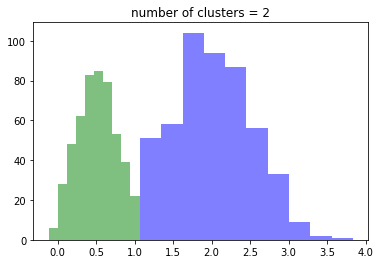

In [16]:
# collect data
v = datagauss['multi'].values
# test uniform
test_uniform_num(v)
# dip test
test_dip(v, alpha = .05)
# get clusters
labels = get_1d_clusters_kde(v)
# plot
plot_1d_clusters_kde(v, labels)

# ANALYSIS 2D

<AxesSubplot:xlabel='n2', ylabel='n3'>

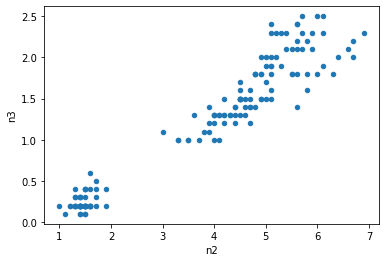

In [70]:
# get data
data2d = data[['n2', 'n3']]
# plot
data2d.plot(kind = 'scatter', x = "n2", y = "n3")

In [71]:
from sklearn.mixture import GaussianMixture
X = data2d.values
n_components = np.arange(1, 11)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in n_components]

In [72]:
gmm_model_comparisons=pd.DataFrame({"n_components" : n_components,
                                  "BIC" : [m.bic(X) for m in models],
                                   "AIC" : [m.aic(X) for m in models]})

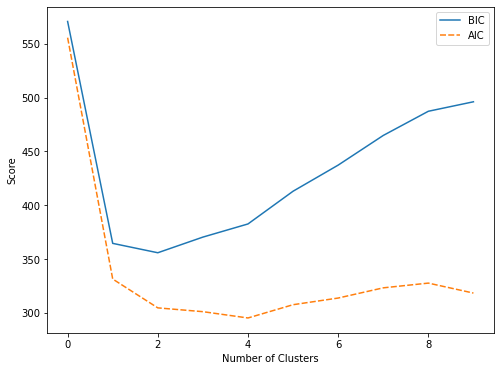

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
sns.lineplot(data=gmm_model_comparisons[["BIC","AIC"]])
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.show()

In [80]:
# get number of clusters
num_clusters = gmm_model_comparisons[gmm_model_comparisons.BIC == gmm_model_comparisons.BIC.min()].index.values[0]

In [81]:
gmm = GaussianMixture(num_clusters, covariance_type='full', random_state=0).fit(X)
labels = gmm.predict(X)
data2d['cluster'] = labels

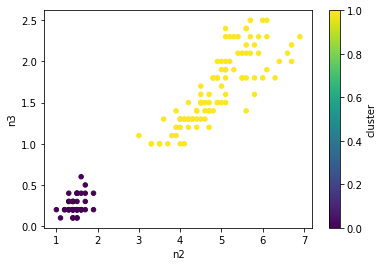

In [82]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
data2d.plot(kind = 'scatter', x = "n2", y = "n3", ax = ax, c = 'cluster', colormap='viridis')
plt.show()

> NOTA: poner como condicion para esta clusterizacion que alguna de la variables o las dos sea multimodal???